## Features+Head Ensemble Starter [LB 0.34] for HMS Brain Comp
We can train 9 model and data variations: (all models included)

**The Ensemble achieves LB 0.34**

| MODEL | DATA TYPE | CV | LB |TRAINING TIME| NOTES |
|----------------|-----------|----------|---|--|--|
| EfficientNetB2 | K | 0.6123 | 0.41 | 2 hours and 58 minutes |K: Kaggle's spectrograms|
| EfficientNetB2 | E | 0.6288 | 0.39 | 2 hours and 57 minutes |E: EEG's spectrograms|
| WaveNet | R | 0.6992 | 0.41 | 3 hours and 35 minutes |R: Raw EEG signals|
| EfficientNetB2 | KE | 0.5646 | 0.37 | 3 hours |KE: Kaggle's and EEG's spectrograms|
| EfficientNetB2 + WaveNet | KR | 0.5912 | 0.39 | 4 hours and 20 minutes |KR: Kaggle's spectrograms and Raw EEG signals|
| EfficientNetB2 + WaveNet | ER | 0.6085 | 0.38 | 4 hours and 22 minutes |ER: EEG's spectrograms and Raw EEG signals|
| EfficientNetB2 + WaveNet | KER | - | 0.36 | 4 hours and 30 minutes |KER: Kaggle's, EEG's spectrograms and Raw EEG signals|
| EfficientNetB2 | K+E | 0.5738 | 0.37 | 5 hours and 42 minutes |K+E: Data spectrogram augmentation|
| EfficientNetB2 | K+E+KE | | 0.36 | 8 hours and 42 minutes |K+E+KE: Data spectrogram augmentation|

Great discussion [here][5] by @KOLOO that led to the latest scores!

Features+Head Starter uses Chris Deotte's Kaggle dataset [here][1]. Also Uses Chris's EEG spectrograms [here][3] (modified version). The Raw EEG signals can be found [here][6]. This notebook is a direct descendent of Chris's notebooks [EfficientNet][2] and [WaveNet][4]

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
[2]: https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57
[3]: https://www.kaggle.com/datasets/nartaa/eeg-spectrograms
[4]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468684
[5]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/477461
[6]: https://www.kaggle.com/datasets/nartaa/hms-eeg

In [9]:
import librosa
import os, random
import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import albumentations as albu
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from scipy.signal import butter, lfilter
import tensorflow.keras.backend as K, gc
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold, GroupKFold

import warnings
warnings.filterwarnings("ignore")

FOLD_NUM = 5


LOAD_BACKBONE_FROM = '/kaggle/input/efficientnetb-tf-keras/EfficientNetB2.h5'
LOAD_MODELS_FROM = '/kaggle/input/features-head-starter-models'
HMS_PATH = '/kaggle/input/hms-harmful-brain-activity-classification'
MODEL_DATA_TYPE = 'K+E+KE'
MODEL = {MODEL_DATA_TYPE: 52} # Setup the model for Training
for DATA_TYPE in MODEL: pass # K|E|R|KE|KR|ER|KER|K+E|K+E+KE
USE_PROCESSED = True # Use processed downsampled Raw EEG 

TEST_MODE = True # USE 500 samples for quick testing
TEST_ENSEMBLE = False # Local Ensemble CV Testing
SUBMISSION = False

# Setup for ensemble
ENSEMBLE = True
MODELS = {
          'K'     : 43, # 'LB':0.41 Kaggle's spectrogram model version
          'E'     : 42, # 'LB':0.39 EEG's spectrogram model version
          'R'     : 37, # 'LB':0.41 EEG's Raw wavenet model version, trained on single GPU
          'KE'    : 47, # 'LB':0.37 Kaggle's and EEG's spectrogram model version
          'KR'    : 48, # 'LB':0.39 Kaggle's spectrogram and Raw model version
          'ER'    : 49, # 'LB':0.38 EEG's spectrogram and Raw model version
          'KER'   : 50, # 'LB':0.36 EEG's, Kaggle's spectrograms and Raw model version
          'K+E'   : 51, # 'LB':0.37 Data spectrogram augmentation model version
          'K+E+KE': 52, # 'LB':0.36 Data spectrogram augmentation model version
         }

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# USE SINGLE GPU, MULTIPLE GPUS 
gpus = tf.config.list_physical_devices('GPU')
# WE USE MIXED PRECISION
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
if len(gpus)>1:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')

Using 1 GPU


# Load and create Non-Overlapping Eeg Id Train Data
The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [10]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']

def eeg_from_parquet(parquet_path):

    eeg = pd.read_parquet(parquet_path, columns=FEATS2)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    data = np.zeros((10_000,len(FEATS2)))
    for j,col in enumerate(FEATS2):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        data[:,j] = x

    return data

def add_kl(data):
    labels = data[TARGETS].values + 1e-5
    data['kl'] = tf.keras.losses.KLDivergence(reduction='none')(
        np.array([[1/6]*6]*len(data)),labels)
    return data
    
if not SUBMISSION:
    train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
    TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    META = ['spectrogram_id','spectrogram_label_offset_seconds','patient_id','expert_consensus']
    train = train.groupby('eeg_id')[META+TARGETS
                           ].agg({**{m:'first' for m in META},**{t:'sum' for t in TARGETS}}).reset_index() 
    train[TARGETS] = train[TARGETS]/train[TARGETS].values.sum(axis=1,keepdims=True)
    train.columns = ['eeg_id','spec_id','offset','patient_id','target'] + TARGETS
    train = add_kl(train)
    print(train.head(1).to_string())

   eeg_id    spec_id  offset  patient_id target  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote        kl
0  568657  789577333     0.0       20654  Other           0.0       0.0      0.25        0.0   0.166667    0.583333  4.584192


# Read Train Spectrograms and EEGs

We can read 3 file from Chris's [Kaggle dataset here][1] which contains all the 11k spectrograms. From Chris's modified EEG spectrogram [here][2]. From Raw EEG signals [here][3]

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
[2]: https://www.kaggle.com/datasets/nartaa/eeg-spectrograms
[3]: https://www.kaggle.com/datasets/nartaa/hms-eeg

In [11]:
%%time
if not SUBMISSION:
    # FOR TESTING SET TEST_MODE TO TRUE
    if TEST_MODE:
        USE_PROCESSED = False
        train = train.sample(500,random_state=42).reset_index(drop=True)
        spectrograms = {}
        for i,e in enumerate(train.spec_id.values):
            if i%100==0: print(i,', ',end='')
            x = pd.read_parquet(f'{HMS_PATH}/train_spectrograms/{e}.parquet')
            spectrograms[e] = x.values
        all_eegs = {}
        for i,e in enumerate(train.eeg_id.values):
            if i%100==0: print(i,', ',end='')
            x = np.load(f'/kaggle/input/eeg-spectrograms/EEG_Spectrograms/{e}.npy')
            all_eegs[e] = x
        all_raw_eegs = {}
        for i,e in enumerate(train.eeg_id.values):
            if i%100==0: print(i,', ',end='')
            x = eeg_from_parquet(f'{HMS_PATH}/train_eegs/{e}.parquet')              
            all_raw_eegs[e] = x
    else:
        spectrograms = None
        all_eegs = None
        all_raw_eegs = None
        if TEST_ENSEMBLE or DATA_TYPE in ['K','KE','K+E','K+E+KE','KR','KER']:
            spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()
        if TEST_ENSEMBLE or DATA_TYPE in ['E','KE','K+E','K+E+KE','ER','KER']:
            all_eegs = np.load('/kaggle/input/eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()
        if TEST_ENSEMBLE or DATA_TYPE in ['R','KR','ER','KER']:
            if USE_PROCESSED:
                all_raw_eegs = np.load('/kaggle/input/hms-eeg/eegs_processed.npy',allow_pickle=True).item()
            else:
                all_raw_eegs = np.load('/kaggle/input/hms-eeg/eegs.npy',allow_pickle=True).item()

0 , 100 , 200 , 300 , 400 , 0 , 100 , 200 , 300 , 400 , 0 , 100 , 200 , 300 , 400 , CPU times: user 28.4 s, sys: 6.15 s, total: 34.5 s
Wall time: 14.6 s


# DATA GENERATOR
This data generator outputs 512x512x3, the spectrogram and eeg images are concatenated all togother in a single image. For using data augmention you can set `augment = True` when creating the train data generator.

In [12]:
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS2,range(len(FEATS2)))}
FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
    
class DataGenerator():
    'Generates data for Keras'
    def __init__(self, data, specs=None, eeg_specs=None, raw_eegs=None , augment=False, mode='train', data_type=DATA_TYPE): 
        self.augment = augment
        self.mode = mode
        self.data_type = data_type
        self.data = self.build_data(data.copy())
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.raw_eegs = raw_eegs
        self.on_epoch_end()
    
    def build_data(self,data):
        if self.data_type in ['K+E']:
            data_dup = pd.concat([data] * 2, ignore_index=True)
            data_dup.loc[:len(data),'data_type'] = 'K'
            data_dup.loc[len(data):,'data_type'] = 'E'
            data = data_dup
        elif self.data_type in ['K+E+KE']:
            data_trp = pd.concat([data] * 3, ignore_index=True)
            data_trp.loc[:len(data),'data_type'] = 'K'
            data_trp.loc[len(data):len(data)*2,'data_type'] = 'E'
            data_trp.loc[len(data)*2:,'data_type'] = 'KE'
            data = data_trp
        else:
            data['data_type'] = self.data_type
        return data
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        X, y = self.data_generation(index)
        if self.augment: X = self.augmentation(X)
        return X, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()
                
    def on_epoch_end(self):
        if self.mode=='train': 
            self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    def data_generation(self, index):
        row = self.data.iloc[index]
        if row.data_type == 'KE':
            X,y = self.generate_all_specs(index)
        elif row.data_type in ['K','E']:
            X,y = self.generate_specs(index)
        elif row.data_type == 'R':
            X,y = self.generate_raw(index)
        elif row.data_type in ['ER','KR']:
            X1,y = self.generate_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        elif row.data_type in ['KER']:
            X1,y = self.generate_all_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        return X,y
    
    def generate_all_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
        
        eeg = self.eeg_specs[row.eeg_id]
        spec = self.specs[row.spec_id]
        
        imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
        img = np.stack(imgs,axis=-1)
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img,np.exp(-4),np.exp(8))
        img = np.log(img)
            
        # STANDARDIZE PER IMAGE
        img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,:256,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,:256,1] = img[:,22:-22,3] # RP_k
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2] # RL_k
        X[100+56:200+56,:256,2] = img[:,22:-22,1] # LP_k
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,256:,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,256:,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,256:,1] = img[:,22:-22,3] # RP_K
        
        # EEG
        img = eeg
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[200+56:300+56,:256,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,:256,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,:256,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,:256,1] = img[:,22:-22,3] # RP_e
        X[200+56:300+56,:256,2] = img[:,22:-22,2] # RL_e
        X[300+56:400+56,:256,2] = img[:,22:-22,1] # LP_e
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,256:,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,256:,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,256:,1] = img[:,22:-22,3] # RP_e

        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
        
        if row.data_type in ['E','ER']:
            img = self.eeg_specs[row.eeg_id]
        elif row.data_type in ['K','KR']:
            spec = self.specs[row.spec_id]
            imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
            img = np.stack(imgs,axis=-1)
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)
            
            # STANDARDIZE PER IMAGE
            img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0]
        X[100+56:200+56,:256,0] = img[:,22:-22,2]
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1]
        X[100+56:200+56,:256,1] = img[:,22:-22,3]
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2]
        X[100+56:200+56,:256,2] = img[:,22:-22,1]
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0]
        X[100+56:200+56,256:,0] = img[:,22:-22,1]
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2]
        X[100+56:200+56,256:,1] = img[:,22:-22,3]
        
        X[200+56:300+56,:256,0] = img[:,22:-22,0]
        X[300+56:400+56,:256,0] = img[:,22:-22,1]
        X[200+56:300+56,:256,1] = img[:,22:-22,2]
        X[300+56:400+56,:256,1] = img[:,22:-22,3]
        X[200+56:300+56,:256,2] = img[:,22:-22,3]
        X[300+56:400+56,:256,2] = img[:,22:-22,2]
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0]
        X[300+56:400+56,256:,0] = img[:,22:-22,2]
        X[200+56:300+56,256:,1] = img[:,22:-22,1]
        X[300+56:400+56,256:,1] = img[:,22:-22,3]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_raw(self,index):
        if USE_PROCESSED and self.mode!='test':
            X = np.zeros((2_000,8),dtype='float32')
            y = np.zeros((6,),dtype='float32')
            row = self.data.iloc[index]
            X = self.raw_eegs[row.eeg_id]
            y[:] = row[TARGETS]
            return X,y
        
        X = np.zeros((10_000,8),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]
            
        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]
            
        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0
            
        # BUTTER LOW-PASS FILTER
        X = self.butter_lowpass_filter(X)
        # Downsample
        X = X[::5,:]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
                
        return X,y
        
    def butter_lowpass_filter(self, data, cutoff_freq=20, sampling_rate=200, order=4):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = lfilter(b, a, data, axis=0)
        return filtered_data
    
    def resize(self, img,size):
        composition = albu.Compose([
                albu.Resize(size[0],size[1])
            ])
        return composition(image=img)['image']
            
    def augmentation(self, img):
        composition = albu.Compose([
                albu.HorizontalFlip(p=0.4)
            ])
        return composition(image=img)['image']

def spectrogram_from_eeg(parquet_path):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((100,300,4),dtype='float32')

    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
            # FILL NANS
            x1 = eeg[COLS[kk]].values
            x2 = eeg[COLS[kk+1]].values
            m = np.nanmean(x1)
            if np.isnan(x1).mean()<1: x1 = np.nan_to_num(x1,nan=m)
            else: x1[:] = 0
            m = np.nanmean(x2)
            if np.isnan(x2).mean()<1: x2 = np.nan_to_num(x2,nan=m)
            else: x2[:] = 0
                
            # COMPUTE PAIR DIFFERENCES
            x = x1 - x2

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//300, 
                  n_fft=1024, n_mels=100, fmin=0, fmax=20, win_length=128)
            
            # LOG TRANSFORM
            width = (mel_spec.shape[1]//30)*30
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
          
    return img

def eeg_from_parquet(parquet_path):

    eeg = pd.read_parquet(parquet_path, columns=FEATS2)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    data = np.zeros((10_000,len(FEATS2)))
    for j,col in enumerate(FEATS2):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        data[:,j] = x

    return data

# DISPLAY DATA GENERATOR
Below we display example data generator spectrogram images and raw EEG signals.

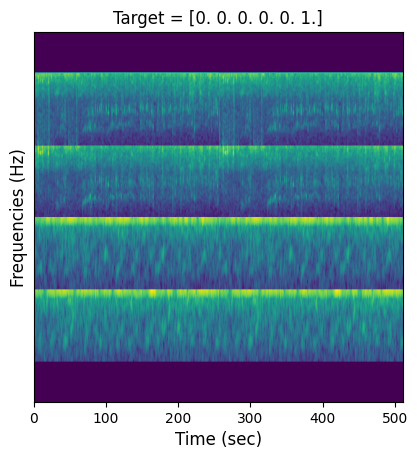

In [13]:
if not SUBMISSION: 
    params = {'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
    gen = DataGenerator(train, augment=False, **params)
    for x,y in gen:
        break
        
    if DATA_TYPE in ['E','K','KE','K+E','K+E+KE','KR','ER','KER']:
        x1 = x[0] if DATA_TYPE in ['KR','ER','KER'] else x
        plt.imshow(x1[:,:,0])
        plt.title(f'Target = {y.round(1)}',size=12)
        plt.yticks([])
        plt.ylabel('Frequencies (Hz)',size=12)
        plt.xlabel('Time (sec)',size=12)
    
    if DATA_TYPE in ['R','KR','ER','KER']:
        x1 = x[1] if DATA_TYPE in ['KR','ER','KER'] else x
        plt.figure(figsize=(20,4))
        offset = 0
        for j in range(x1.shape[-1]):
            if j!=0: offset -= x1[:,j].min()
            plt.plot(range(2_000),x1[:,j]+offset,label=f'feature {j+1}')
            offset += x1[:,j].max()
        plt.legend()
        
    plt.show()

# TRAINING

## LEARNING RATE

In [14]:

if not SUBMISSION:

    def lrfn(epoch):
        e3 = 1e-3 if DATA_TYPE in ['R'] else 1e-4
        return [1e-3,1e-3,e3,1e-4,1e-5][epoch]

    LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    
    def lrfn2(epoch):
        return [1e-5,1e-5,1e-6][epoch]

    LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn2, verbose = True)

## MODEL AND UTILITY FUNCTIONS

In [15]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate, LayerNormalization


def build_model(data_type=DATA_TYPE):
    K.clear_session()
    with strategy.scope():
        if data_type in ['R']:
            model = build_wave_model()
        elif data_type in ['K','E','KE','K+E','K+E+KE']:
            model = build_spec_model()
        elif data_type in ['KR','ER','KER']:
            model = build_hybrid_model()
    return model

def build_spec_model(hybrid=False):  
    inp = tf.keras.layers.Input((512,512,3))
    base_model = load_model(f'{LOAD_BACKBONE_FROM}')    
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if not hybrid:
        x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)  
    return model

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

def build_wave_model(hybrid=False):
        
    # INPUT 
    inp = tf.keras.Input(shape=(2_000,8))
    
    ############
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wave_block(inp2, 8, 4, 6)
    x = wave_block(x, 16, 4, 6)
    x = wave_block(x, 32, 4, 6)
    x = wave_block(x, 64, 4, 6)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    if not hybrid:
        y = tf.keras.layers.Dense(64, activation='relu')(y)
        y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

def build_hybrid_model():
    model_spec = build_spec_model(True)
    model_wave = build_wave_model(True)
    inputs = [model_spec.input, model_wave.input]
    x = [model_spec.output, model_wave.output]
    x = tf.keras.layers.Concatenate()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inputs, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

def score(y_true, y_pred):
    kl = tf.keras.metrics.KLDivergence()
    return kl(y_true, y_pred)

def plot_hist(hist):
    metrics = ['loss']
    for i,metric in enumerate(metrics):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,i+1)
        plt.plot(hist[metric])
        plt.plot(hist[f'val_{metric}'])
        plt.title(f'{metric}',size=12)
        plt.ylabel(f'{metric}',size=12)
        plt.xlabel('epoch',size=12)
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
        
def dataset(data, mode='train', batch_size=8, data_type=DATA_TYPE, 
            augment=False, specs=None, eeg_specs=None, raw_eegs=None):
    
    BATCH_SIZE_PER_REPLICA = batch_size
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    gen = DataGenerator(data,mode=mode, data_type=data_type, augment=augment,
                       specs=specs, eeg_specs=eeg_specs, raw_eegs=raw_eegs)
    if data_type in ['K','E','KE','K+E','K+E+KE']: 
        inp = tf.TensorSpec(shape=(512,512,3), dtype=tf.float32)
    elif data_type in ['KR','ER','KER']:
        inp = (tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),tf.TensorSpec(shape=(2000,8), dtype=tf.float32))
    elif data_type in ['R']:
        inp = tf.TensorSpec(shape=(2000,8), dtype=tf.float32)
        
    output_signature = (inp,tf.TensorSpec(shape=(6,), dtype=tf.float32))
    dataset = tf.data.Dataset.from_generator(generator=gen, output_signature=output_signature).batch(
        BATCH_SIZE)
    return dataset

def reset_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
        
def get_size(x):
    if DATA_TYPE in ['K+E']:
        size = 2*len(x)
    elif  DATA_TYPE in ['K+E+KE']:
        size = 3*len(x)
    else:
        size = len(x)
    return size

def predict(models, params, fold, models_path=None):
    preds = []
    if models_path is None: models_path = LOAD_MODELS_FROM
    model_wave = build_wave_model()
    model_spec = build_spec_model()
    model_hybrid = build_hybrid_model()
    for data_type in models:
        data = params['data']
        ver = models[data_type]
        ds = dataset(data_type=data_type, **params)
        if data_type in ['R']:
            model = model_wave
        elif data_type in ['K','E','KE','K+E','K+E+KE']:
            model = model_spec
        elif data_type in ['KR','ER','KER']:
            model = model_hybrid
        model.load_weights(f'{models_path}/model_{data_type}_{ver}_{fold}.weights.h5')
        pred = model.predict(ds)
        if data_type in ['K+E']:
            pred = (pred[:len(data)] + pred[len(data):])/2
        if data_type in ['K+E+KE']:
            pred = (pred[:len(data)] + pred[len(data):len(data)*2] + pred[len(data)*2:])/3
        preds.append(pred)
    pred = np.mean(preds,axis=0)
    del model_wave, model_spec, model_hybrid
    gc.collect()
    return pred

## TRANSFER LEARNING

#########################
### Fold 0
### train size 1311, valid size 189
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5
164/164 [==============================] - 43s 104ms/step - loss: 1.2105 - val_loss: 1.6080 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
164/164 [==============================] - 15s 94ms/step - loss: 0.9653 - val_loss: 1.2300 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
164/164 [==============================] - 15s 93ms/step - loss: 0.7339 - val_loss: 1.1084 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
164/164 [==============================] - 15s 93ms/step - loss: 0.5510 - val_loss: 1.0169 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
164/164 [==============================] - 15s 93ms/step - loss: 0.4568 - val_loss: 1.0284 - lr: 1.0000e

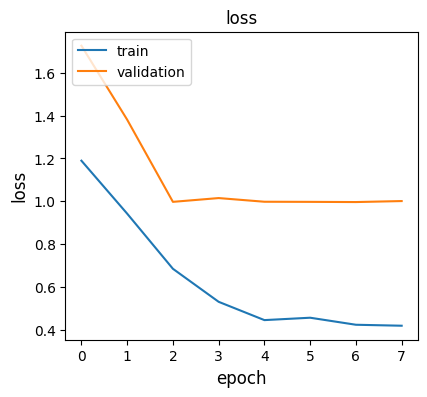

CV KL SCORE: 0.8580


In [16]:
if not SUBMISSION and not TEST_ENSEMBLE:
    reset_seed(42)
    all_oof = []
    all_true = []
    val_sizes = []
    losses = []
    val_losses = []
    total_hist = {}

    # gkf = GroupKFold(n_splits=5)
    # for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):
    for fold in range(FOLD_NUM):
        print('#'*25)
        print(f'### Fold {fold}')
        valid_ids_path = f"/kaggle/input/valid_eeg_ids_fold{fold}.yaml"
        with open(valid_ids_path, 'r') as file:
            valid_ids = yaml.load(file, Loader=yaml.FullLoader)
        
        params = {'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
        # data, val = train.iloc[train_index],train.iloc[valid_index]
        data = train[~train.eeg_id.isin(valid_ids)]
        val = train[train.eeg_id.isin(valid_ids)]
        train_index = data.index
        valid_index = val.index
        train_dataset = dataset(data, **params)
        val_dataset = dataset(val, mode='valid', **params)
        data = data[data['kl']<5.5]
        train_dataset2 = dataset(data, **params)
        train_size = get_size(train_index)
        valid_size = get_size(valid_index)
        print(f'### train size {train_size}, valid size {valid_size}')
        print('#'*25)
        model = build_model()
        hist = model.fit(train_dataset, validation_data = val_dataset, 
                         epochs=5, callbacks=[LR])
        train_size = get_size(data)
        print(f'### seconds stage train size {train_size}, valid size {valid_size}')
        print('#'*25)
        hist2 = model.fit(train_dataset2, validation_data = val_dataset, 
                         epochs=3, callbacks=[LR2])
        losses.append(hist.history['loss']+hist2.history['loss'])
        val_losses.append(hist.history['val_loss']+hist2.history['val_loss'])
        with strategy.scope():
            model_dir = os.path.join("/kaggle/working", MODEL_DATA_TYPE)
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            model_path = os.path.join(model_dir, f'model_{DATA_TYPE}_{MODEL[DATA_TYPE]}_{fold}.weights.h5')
            model.save_weights(model_path)
        params = {'mode':'valid','data':val,'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
        oof = predict(MODEL, params, fold, models_path=model_dir)
        all_oof.append(oof)
        all_true.append(train.iloc[valid_index][TARGETS].values)
        val_sizes.append(len(valid_index))
        del model, oof
        gc.collect()
        
    total_hist['loss'] = np.mean(losses,axis=0)
    total_hist['val_loss'] = np.mean(val_losses,axis=0)
    all_oof = np.concatenate(all_oof)
    all_true = np.concatenate(all_true)
    plot_hist(total_hist)
    print(f'CV KL SCORE: {score(all_true,all_oof):.4f}')

## Local Ensemble Testing on CV

In [18]:
MODELS = {
    #   'K'     : 43, # 'LB':0.41 Kaggle's spectrogram model version
    #   'E'     : 42, # 'LB':0.39 EEG's spectrogram model version
    #   'R'     : 37, # 'LB':0.41 EEG's Raw wavenet model version, trained on single GPU
#           'KE'    : 47, # 'LB':0.37 Kaggle's and EEG's spectrogram model version
#           'KR'    : 48, # 'LB':0.39 Kaggle's spectrogram and Raw model version
#           'ER'    : 49, # 'LB':0.38 EEG's spectrogram and Raw model version
#           'KER'   : 50, # 'LB':0.36 EEG's, Kaggle's spectrograms and Raw model version
#           'K+E'   : 51, # 'LB':0.37 Data spectrogram augmentation model version
        'K+E+KE': 52, # 'LB':0.36 Data spectrogram augmentation model version
        }
reset_seed(42)
# gkf = GroupKFold(n_splits=5)
all_oof = []
all_true = []
# for i, (_, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
#     print(f'Fold {i+1}')
#     val_data = train.iloc[valid_index].copy()
oof_df = train[["eeg_id"] + TARGETS].copy()
pred_cols = [f"pred_{c}" for c in TARGETS]
oof_df[pred_cols] = 0
for fold in range(FOLD_NUM):
    print('#'*25)
    print(f'### Fold {fold+1}')
    valid_ids_path = f"/kaggle/input/valid_eeg_ids_fold{fold}.yaml"
    with open(valid_ids_path, 'r') as file:
        valid_ids = yaml.load(file, Loader=yaml.FullLoader)
    
    params = {'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
    # data, val = train.iloc[train_index],train.iloc[valid_index]
    val_data = train[train.eeg_id.isin(valid_ids)]
    valid_index = val.index
    params = {'mode':'valid','data':val_data,'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
    model_dir = os.path.join("/kaggle/working", MODEL_DATA_TYPE)
    oof = predict(MODELS, params, fold, model_dir)
    all_oof.append(oof)
    all_true.append(val_data[TARGETS].values)
    oof_df.loc[val_data.index, pred_cols] = oof
    print(f'Fold {fold+1} KL SCORE: {score(val_data[TARGETS].values, oof):.4f}')

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
print(f'CV KL SCORE: {score(all_true,all_oof):.4f}')

#########################
### Fold 1
24/24 [==============================] - 1s 26ms/step
Fold 1 KL SCORE: 0.9059
#########################
### Fold 2
26/26 [==============================] - 2s 26ms/step
Fold 2 KL SCORE: 0.6441
#########################
### Fold 3
26/26 [==============================] - 2s 25ms/step
Fold 3 KL SCORE: 0.9730
#########################
### Fold 4
27/27 [==============================] - 2s 25ms/step
Fold 4 KL SCORE: 1.0016
#########################
### Fold 5
32/32 [==============================] - 2s 25ms/step
Fold 5 KL SCORE: 0.7832
CV KL SCORE: 0.8580
